In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

import os

# pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.12.1-py3-none-any.whl
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [7]:
df_train = pd.read_csv('data/train.csv')
print(df_train.shape)
df_train = df_train.dropna(how = 'any', axis =0)
print(df_train.shape)
df_train.head()

(404290, 6)
(404287, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
df_test = pd.read_csv('data/test.csv')
print(df_test.shape)
df_test = df_test.dropna(how = 'any', axis =0)
print(df_test.shape)
df_test.head()

(3563475, 3)
(3563466, 3)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [9]:
df_train.describe(include='all')

,id,qid1,qid2,question1,question2,is_duplicate
count,404287.000000,404287.000000,404287.000000,404287,404287,404287.000000
unique,NaN,NaN,NaN,290455,299173,NaN
top,NaN,NaN,NaN,How do I improve my English speaking?,How can you look at someone's private Instagra...,NaN
freq,NaN,NaN,NaN,50,120,NaN
mean,202144.340337,217243.151093,220955.212082,NaN,NaN,0.369201
std,116708.673691,157751.614317,159903.168488,NaN,NaN,0.482589
min,0.000000,1.000000,2.000000,NaN,NaN,0.000000
25%,101071.500000,74436.500000,74726.500000,NaN,NaN,0.000000
50%,202145.000000,192181.000000,197053.000000,NaN,NaN,0.000000
75%,303216.500000,346573.000000,354692.000000,NaN,NaN,1.000000


In [10]:
df_test.describe(include='all')

,test_id,question1,question2
count,3563466,3563466,3563466
unique,2607933,2211005,2227397
top,1303971,What,What
freq,2,2033,2016


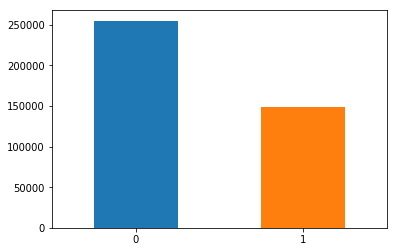

In [11]:
df_train['is_duplicate'].value_counts().plot(kind="bar", rot=0)

We'll use a simple logistic regression with 3-fold stratified cross-validation for fast evaluation.

In [14]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:598: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("

Log loss: 0.34456225154048725
Accuracy: 0.9466666666666667


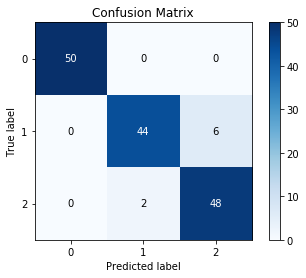

In [15]:
# Quick test of evaluate_features
from sklearn.datasets import load_iris
evaluate_features(*load_iris(True))

In [16]:
df_text = pd.DataFrame(df_train['question1'].append(df_train['question2']), columns=['question'])
df_text

,question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."
5,Astrology: I am a Capricorn Sun Cap moon and c...
6,Should I buy tiago?
7,How can I be a good geologist?
8,When do you use シ instead of し?
9,Motorola (company): Can I hack my Charter Moto...


### Baseline Bag of Words

In [17]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)   

In [18]:
bag_of_words1 = count_vectorizer.fit_transform(df_train['question1'].values.astype('U'))
bag_of_words2 = count_vectorizer.fit_transform(df_train['question2'].values.astype('U'))

In [20]:
len(count_vectorizer.get_feature_names())

78730

In [21]:
count_vectorizer.get_feature_names()

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'+",
 "'-",
 "'0",
 "'08",
 "'1",
 "'10",
 "'10-4",
 "'100",
 "'10n'.how",
 "'14",
 "'15",
 "'16",
 "'17",
 "'1984",
 "'1^2",
 "'2",
 "'2048",
 "'3-act",
 "'363^1/2",
 "'40s",
 "'60s",
 "'7",
 "'70s",
 "'786",
 "'80s",
 "'88",
 "'8888",
 "'90",
 "'90s",
 "'^",
 "'a",
 "'a2a",
 "'aadaab",
 "'aamdaar",
 "'aanvla",
 "'aap",
 "'aatank",
 "'aavashyakta",
 "'aawad",
 "'abbreviated",
 "'about",
 "'abram",
 "'abramic",
 "'absolutely",
 "'accelerated",
 "'acquiesce",
 "'active",
 "'adam",
 "'added",
 "'adduce",
 "'adholiekhit",
 "'advanced",
 "'adverse",
 "'ae",
 "'after",
 "'ainvayi",
 "'air",
 "'aiyyo",
 "'akik",
 "'akkhiel",
 "'akshar",
 "'aliens",
 "'align",
 "'all",
 "'alma",
 "'alpha",
 "'alt-right",
 "'although",
 "'amba",
 "'amchi",
 "'amen",
 "'american",
 "'among",
 "'amongst",
 "'an",
 "'anachronism",
 "'analog",
 "'anasir",
 "'anatomy",
 "'and",
 "'ands",
 "'angle",
 "'anonymous",
 "'antibiotic",
 "'anushasan",
 "'any",
 "'anyway",
 "'any

In [22]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words1 = svd.fit_transform(bag_of_words1)
truncated_bag_of_words2 = svd.fit_transform(bag_of_words2)

In [23]:
print(truncated_bag_of_words1.shape)
print(truncated_bag_of_words2.shape)

(404287, 25)
(404287, 25)


In [25]:
truncated_bag_of_words = np.concatenate((truncated_bag_of_words1,truncated_bag_of_words2), axis = 1)
print(truncated_bag_of_words.shape)

(404287, 50)


/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:598: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished


Log loss: 0.6100230833315748
Accuracy: 0.6678968158758506


/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


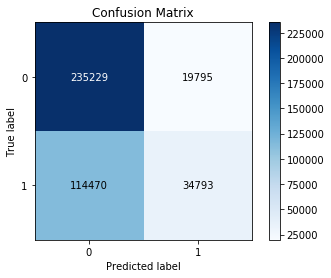

In [26]:
evaluate_features(truncated_bag_of_words, df_train['is_duplicate'].values.ravel())

In [27]:
evaluate_features(truncated_bag_of_words, df_train['is_duplicate'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:598: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

### TFIDF

In [ ]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf1 = count_vectorizer.fit_transform(df_train['question1'].values.astype('U'))
tfidf2 = count_vectorizer.fit_transform(df_train['question2'].values.astype('U'))

len(count_vectorizer.get_feature_names())

In [ ]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf1 = svd.fit_transform(tfidf1)
truncated_tfidf2 = svd.fit_transform(tfidf2)
truncated_tfidf = np.concatenate((truncated_tfidf1,truncated_tfidf2), axis = 1)

In [ ]:
evaluate_features(truncated_tfidf, df_train['is_duplicate'].values.ravel())

In [ ]:
evaluate_features(truncated_tfidf, df_train['is_duplicate'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

Also tried a linear SVM for features straight from TFIDF (did not go through Truncated SVD). Worse log loss but confusion matrix seems to show better balance among predicted classes.

In [ ]:
evaluate_features(tfidf, df_train['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

### Word2Vec

In [28]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [29]:
w2vec = get_word2vec(
    MySentences(
        df_train['question1'].values, 
        df_train['question2'].values, 
        #df_test['question1'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk


In [30]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [32]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded1 = mean_embedding_vectorizer.fit_transform(df_train['question1'])
mean_embedded2 = mean_embedding_vectorizer.fit_transform(df_train['question2'])
mean_embedded = np.concatenate((mean_embedded1,mean_embedded2), axis = 1)

/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:598: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Log loss: 0.5628599529134157
Accuracy: 0.718561319062943


/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


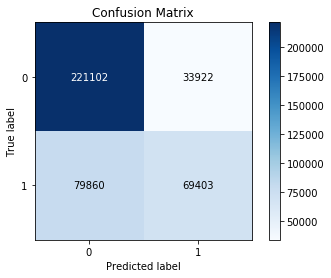

In [33]:
evaluate_features(mean_embedded, df_train['is_duplicate'].values.ravel())

In [34]:
evaluate_features(mean_embedded, df_train['is_duplicate'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:598: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [35]:
evaluate_features(mean_embedded, 
                  df_train['is_duplicate'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

/Users/ksun/Downloads/venv3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:598: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


XGBoostError: b'value 0 for Parameter num_class should be greater equal to 1'

The results are still not very good though (but better than tfidf). One way to explain this is that there is a lot of information loss from just getting the mean of all word vectors of the document. This is roughly analogous to taking the entire document, summarizing it into one word, and using that word to classify the entire text.
### Let's try a quick and dirty LSTM in Keras to take into account the sequential nature of text

In [ ]:
df_train_lstm = (df_train["question1"].map(str) + df_train["question2"]).astype(str)
print(df_train_lstm.shape)
df_train_lstm.head()

In [ ]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train_lstm.values)

In [ ]:
# Pad the data 
X = tokenizer.texts_to_sequences(df.values)
X = pad_sequences(X, maxlen=2000)

In [ ]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

In [ ]:
Y = pd.get_dummies(df_train['is_duplicate']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

In [ ]:
model = load_model('keras_model')

In [ ]:
probas = model.predict(X_test)

In [ ]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)